In [88]:
# Set to false if working on local env
onColab = True

model_path = './inno_training_prep_std_mean_smooth4'

# Decide batch size and validation split
batch_size = 128
validation_split = 0.2
test_split = 0.01
epochs = 200

dataset_path = './Training_smooth4.csv'

window = 600
stride = 10
telescope = 108

In [89]:
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE2
  !ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1wUooQX2JQMXbJQAiDLoK7kUddfk8JdBM/CHALLENGE2
analysis.ipynb
autoencoder_1_512
autoencoder_1_512.h5
baseline
baseline_2
baseline_2_ckpt
baseline_3
baseline_3_ckpt
baseline_3_forSub
baseline_3_training_smooth
baseline_3_training_smooth_ckpt
baseline_4
baseline_4_ckpt
baseline_5
baseline_5_ckpt
baseline_ckpt
baseline.ipynb
d2ee2_ERR_smooth_training.ipynb
d2ee2_smooth_training.ipynb
d2ee2_tl_with_weigths_smooth_training.ipynb
err_7.csv
inno_training_and_bid_smooth4
inno_training_diff_prep_smooth4
inno_training_fft_1
inno_training_lowpass_1
inno_training_prep_std_mean_autoencoder1
inno_training_prep_std_mean_smooth4
inno_training_smooth
inno_training_smooth_2
inno_training_smooth_3
inno_training_smooth_4
inno_training_smooth_4_1
inno_training_smooth_5
inno_training_smooth_6
inno_training_smooth_7
inno_training_smooth_7_ERR
inno_training_tl_weight

In [90]:
#@title Import libraries
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [91]:
#@title init seed everywhere
seed =20

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [92]:
dataset  = pd.read_csv(dataset_path)
print(dataset.shape)
dataset.head()

(68480, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,5.484983,5.713692,8.924425,2.845270,3.602428,31.723626,4.450450
1,5.485001,5.713655,8.924425,2.845263,3.602416,31.723948,4.450430
2,5.485237,5.713199,8.924437,2.845175,3.602270,31.727915,4.450184
3,5.486135,5.711522,8.924551,2.844837,3.601726,31.742346,4.449323
4,5.488279,5.707682,8.924995,2.844031,3.600466,31.775062,4.447453


In [93]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68480 entries, 0 to 68479
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68480 non-null  float64
 1   Wonder level        68480 non-null  float64
 2   Crunchiness         68480 non-null  float64
 3   Loudness on impact  68480 non-null  float64
 4   Meme creativity     68480 non-null  float64
 5   Soap slipperiness   68480 non-null  float64
 6   Hype root           68480 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


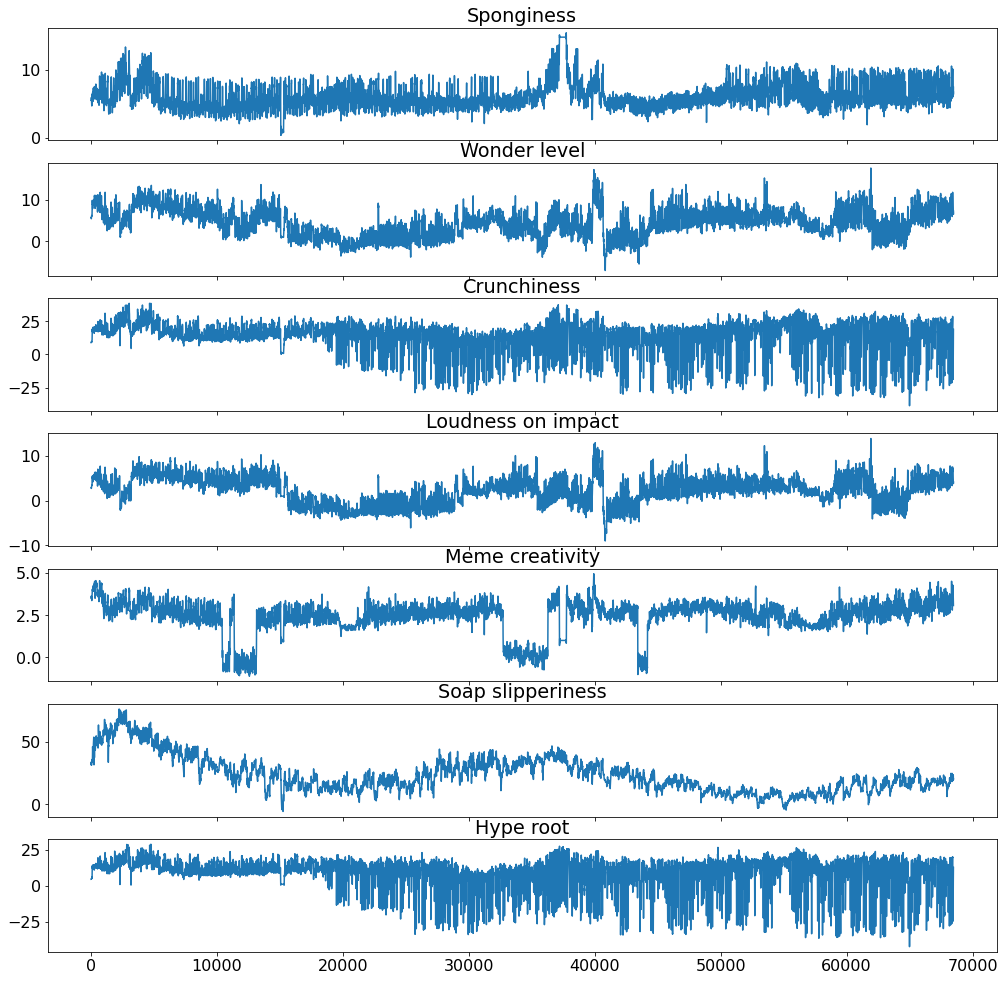

In [94]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

In [95]:
test_size = round(dataset.shape[0] * test_split)
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_mean = X_train_raw.mean()
X_std = X_train_raw.std()

X_train_noNorm = X_train_raw
X_test_noNorm = X_test_raw

## min-max, then multiply by 2 then elevate to power of 2 to accentuate variance
X_train_raw = (X_train_raw - X_mean) / X_std
X_test_raw = (X_test_raw - X_mean) / X_std


(67795, 7) (685, 7)


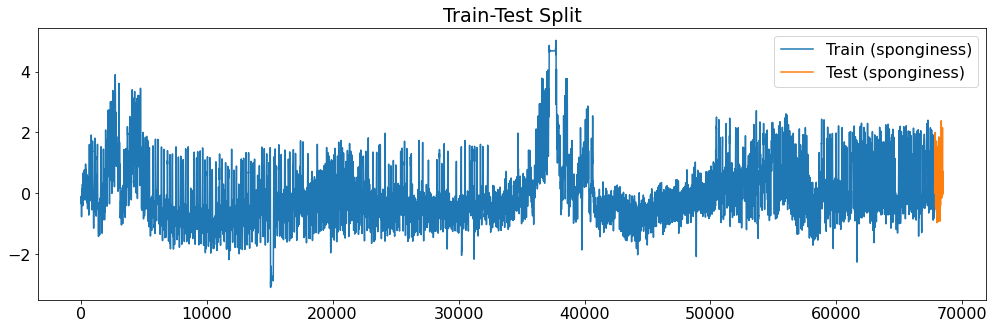

In [96]:
plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [97]:
future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 600, 7)

In [98]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [99]:
target_labels = dataset.columns

In [100]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6710, 600, 7), (6710, 108, 7), (50, 600, 7), (50, 108, 7))

In [101]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        # axs[i].set_ylim(0,1)
    plt.show()

In [102]:
X_train.shape

(6710, 600, 7)

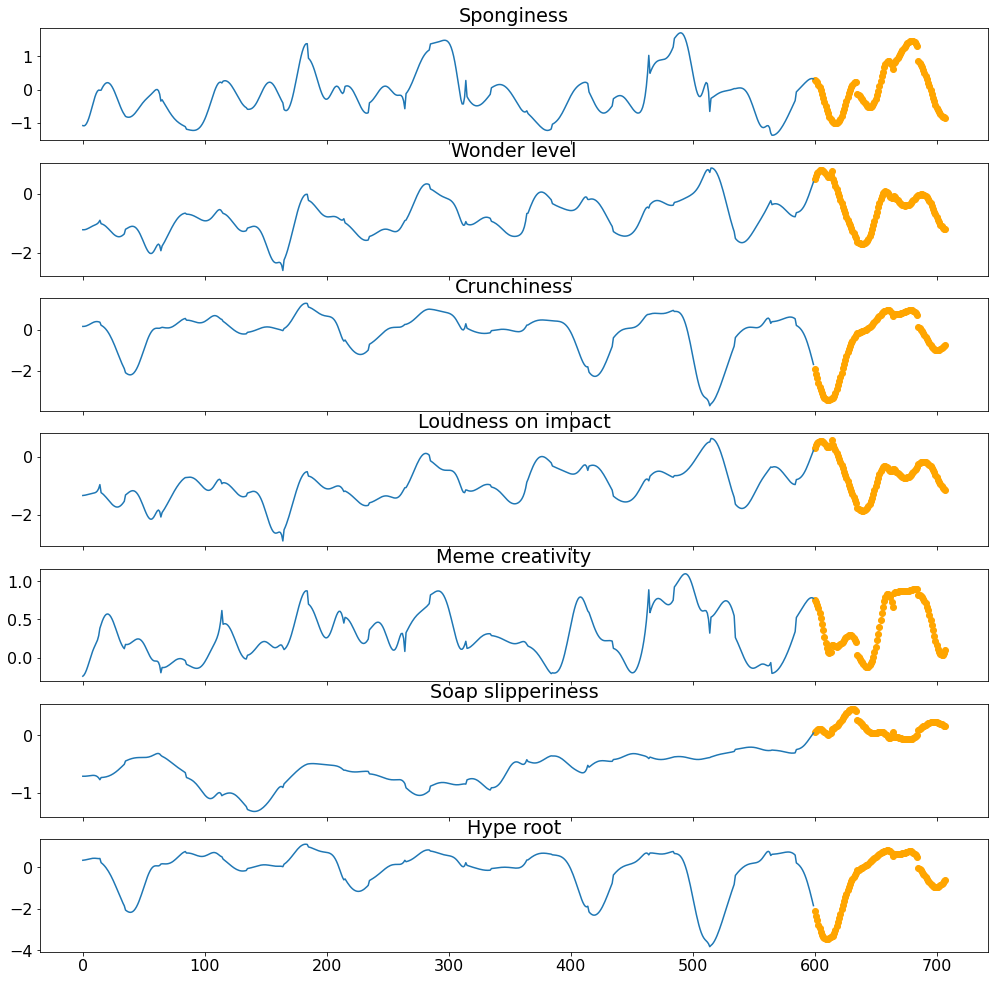

In [103]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [104]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
input_shape, output_shape

((600, 7), (108, 7))

In [136]:

# def custom_activation(x):
#     return (K.sigmoid(x) * 5) - 1

# get_custom_objects().update({'custom_activation': Activation(custom_activation)})

# # Usage
# model = Sequential()
# model.add(Dense(32, input_dim=784))
# model.add(Activation(custom_activation, name='SpecialActivation'))

# def cubic_activation(x):
#   return x ** 3

def sig(x):
  return tfk.backend.abs(x) * tfk.backend.tanh(x)

def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    # E1D1
    n_features = input_shape[1]
    n_past = input_shape[0]
    n_future = output_shape[0]

    #
    encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))    
    conv = tfkl.Conv1D(512, 3, padding='same')(encoder_inputs)
    # conv = tfkl.LeakyReLU(alpha=0.03)(conv)
    conv = tfkl.Activation(sig, name='sig')(conv)

    encoder_l1 = tf.keras.layers.LSTM(256, return_state=True)
    encoder_outputs1 = encoder_l1(conv)

    encoder_states1 = encoder_outputs1[1:]

    #
    decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

    #
    decoder_l1 = tf.keras.layers.LSTM(256, return_sequences=True, recurrent_dropout=0.3)(decoder_inputs,initial_state = encoder_states1)
    decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
    decoder_outputs1 = tfkl.Activation(sig, name='sig2')(decoder_outputs1)
    # let's give the net another chance to set good values
    decoder_outputs1 = tfkl.Dense(output_shape[0] * output_shape[1] * 2)(tfkl.Reshape((output_shape[0] * output_shape[1],))(decoder_outputs1))
    decoder_outputs1 = tfkl.Reshape(output_shape)(tfkl.Dense(output_shape[0] * output_shape[1])(decoder_outputs1))

    #
    model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

    model_e1d1.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    return model_e1d1

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 600, 7)]     0           []                               
                                                                                                  
 conv1d_19 (Conv1D)             (None, 600, 512)     11264       ['input_21[0][0]']               
                                                                                                  
 sig (Activation)               (None, 600, 512)     0           ['conv1d_19[0][0]']              
                                                                                                  
 lstm_30 (LSTM)                 [(None, 256),        787456      ['sig[0][0]']                    
                                 (None, 256),                                              

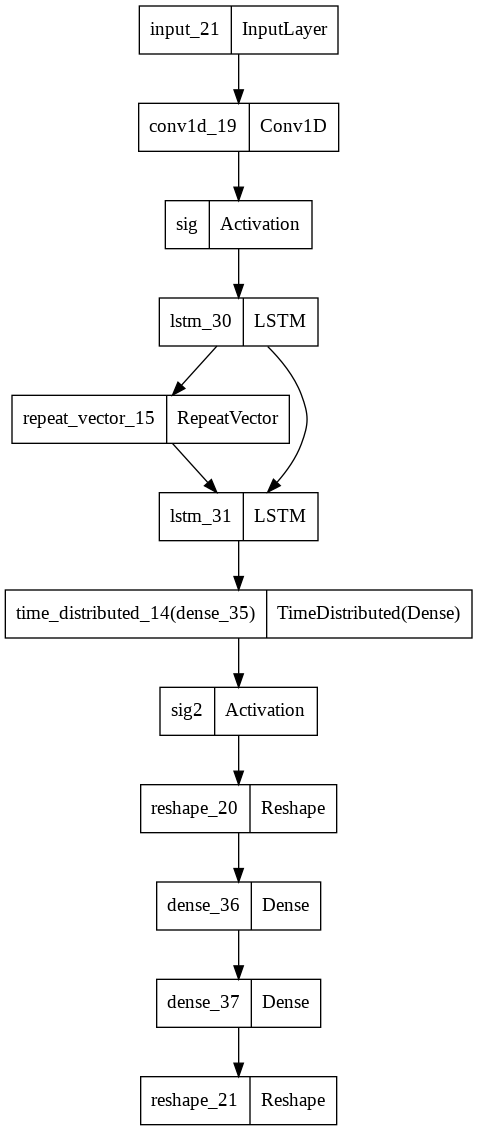

In [137]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [138]:
def updateRate(currEpoch, currRate):
  if currEpoch == 0:
    return currRate
  elif currEpoch % 10 == 0:
    return currRate * 3 / 4
  return currRate

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = validation_split,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5),
        tf.keras.callbacks.LearningRateScheduler(updateRate, verbose=0)
        # tfk.callbacks.ModelCheckpoint(model_path + '_ckpt', save_best_only=True)
    ]
).history

Epoch 1/200
42/42 [==============================] - 59s 900ms/step - loss: 0.5824 - mae: 0.5633 - val_loss: 0.6495 - val_mae: 0.5794 - lr: 0.0010
Epoch 2/200
42/42 [==============================] - 37s 874ms/step - loss: 0.4215 - mae: 0.4659 - val_loss: 0.6237 - val_mae: 0.5590 - lr: 0.0010
Epoch 3/200
42/42 [==============================] - 37s 875ms/step - loss: 0.3693 - mae: 0.4394 - val_loss: 0.5249 - val_mae: 0.5131 - lr: 0.0010
Epoch 4/200
42/42 [==============================] - 37s 872ms/step - loss: 0.3294 - mae: 0.4175 - val_loss: 0.4899 - val_mae: 0.4986 - lr: 0.0010
Epoch 5/200
42/42 [==============================] - 37s 876ms/step - loss: 0.2988 - mae: 0.3961 - val_loss: 0.4816 - val_mae: 0.4935 - lr: 0.0010
Epoch 6/200
42/42 [==============================] - 37s 879ms/step - loss: 0.2741 - mae: 0.3768 - val_loss: 0.4606 - val_mae: 0.4848 - lr: 0.0010
Epoch 7/200
42/42 [==============================] - 37s 871ms/step - loss: 0.2662 - mae: 0.3710 - val_loss: 0.4534 - 

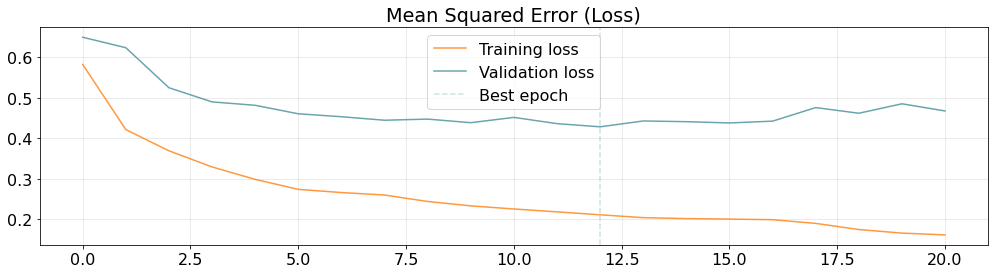

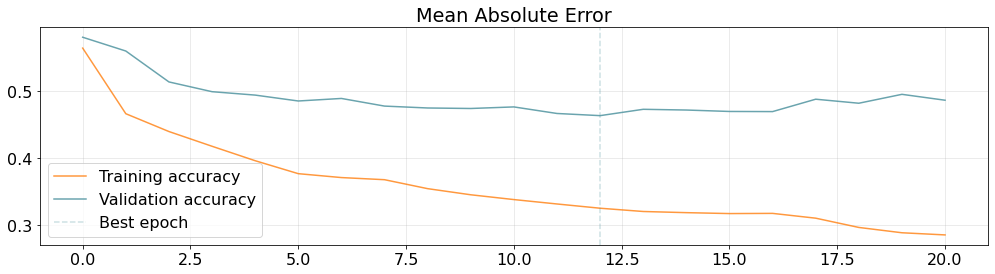

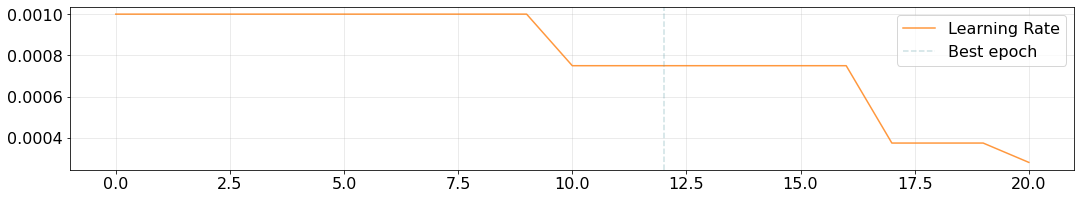

In [139]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [140]:
model.save(model_path)

In [141]:
model = tfk.models.load_model(model_path)

In [142]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(50, 108, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.38663352>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.43342084>)

In [143]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        # axs[i].set_ylim(0,1)
    plt.show()

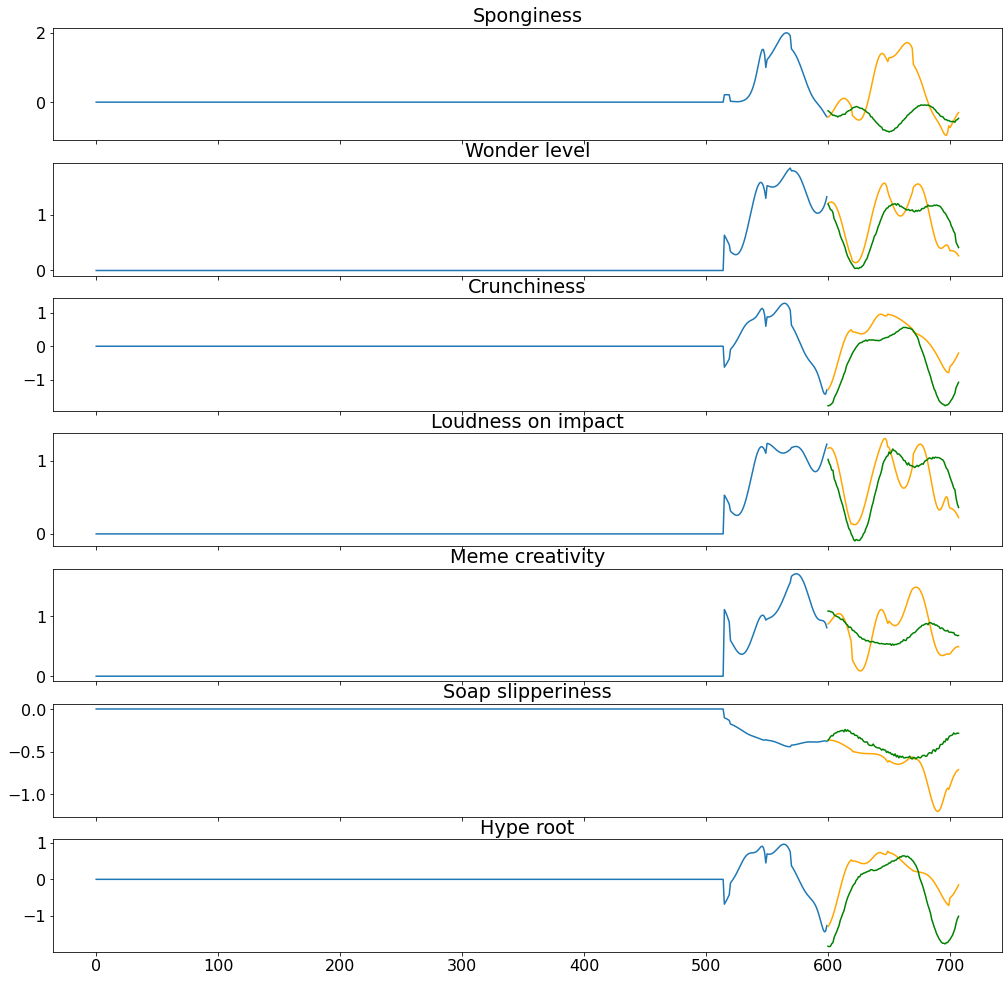

In [144]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [145]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [146]:
future_predictions = model.predict(future)

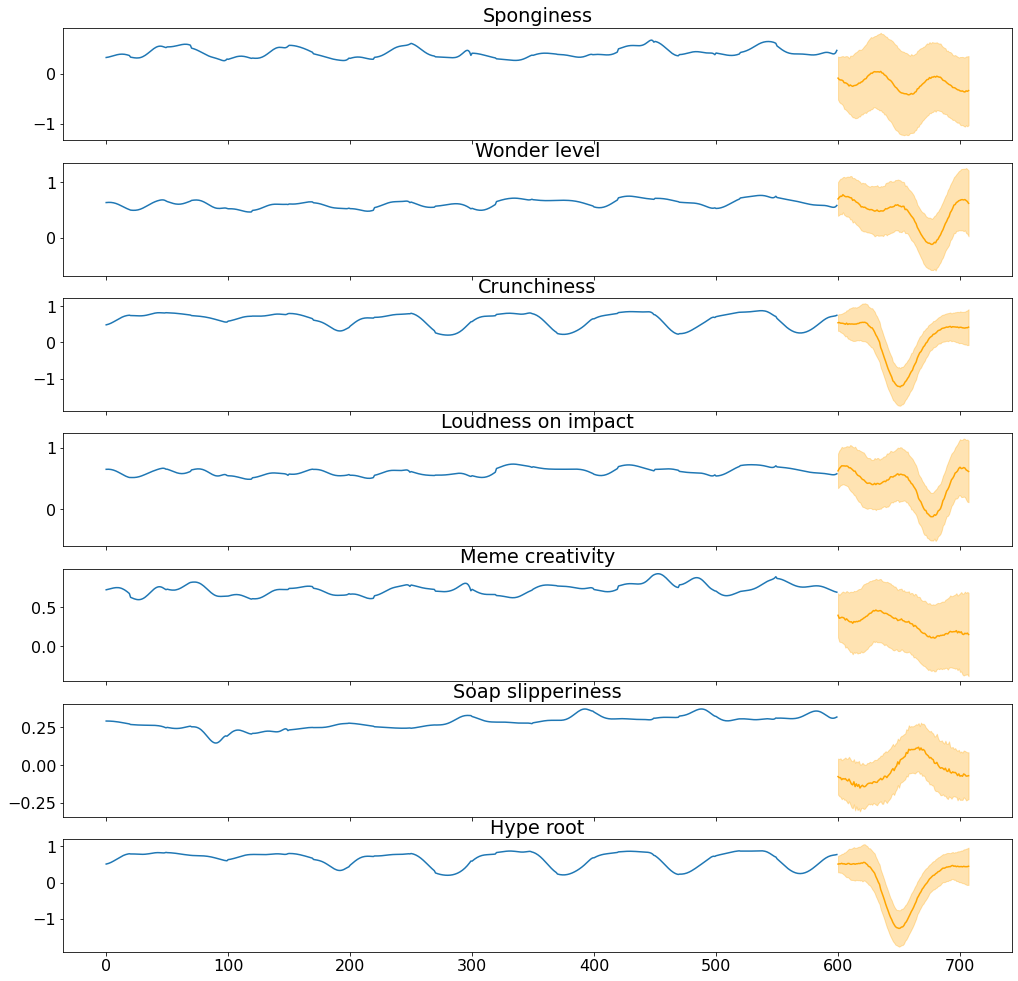

In [147]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), future_predictions[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), 
        future_predictions[0,:,i]+maes[:,i], 
        future_predictions[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()

In [148]:
reg_telescope = 216
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((39, 600, 7), (39, 216, 7))

In [149]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,reg_telescope,telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

In [150]:
reg_predictions.shape

(39, 216, 7)

In [151]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.45737007>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.4840378>)

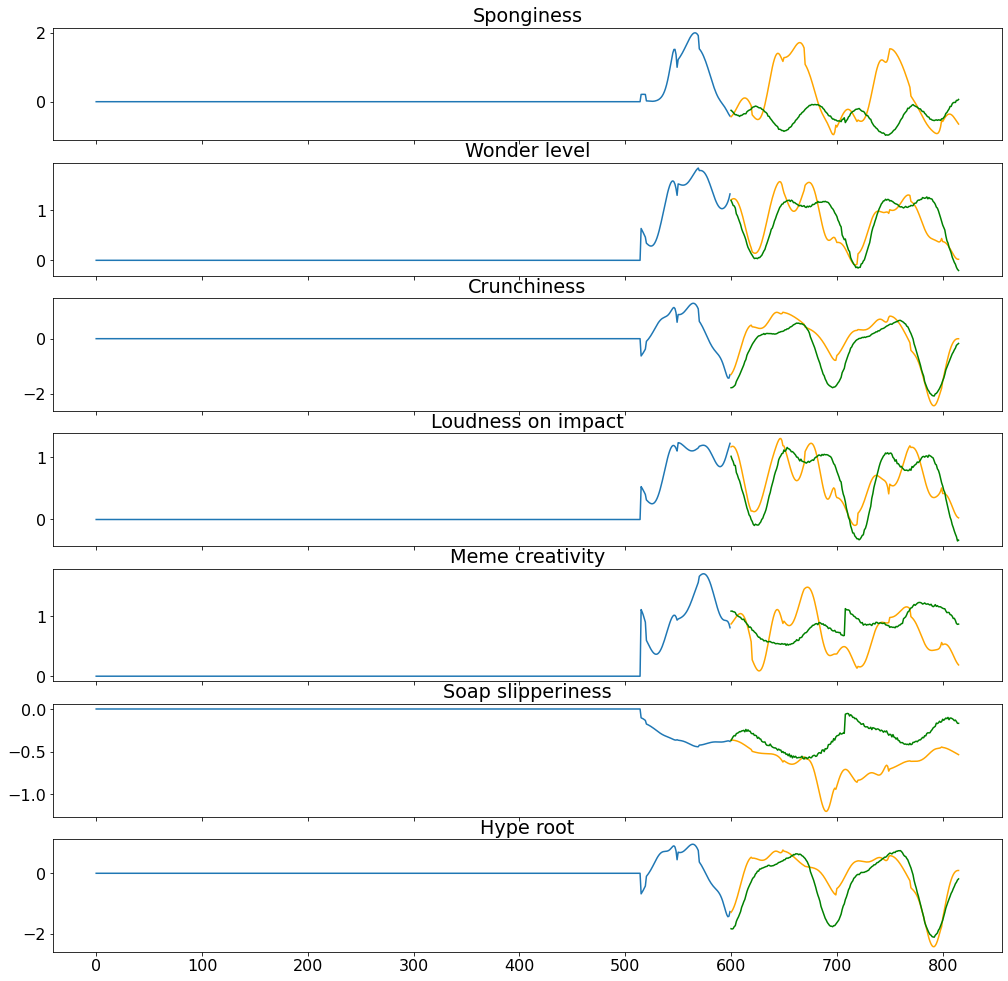

In [152]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)